
# The Truck Dataset

The purpose of this notebook is to generate a synthetic dataset of failure
times with and without censoring to study survival analysis and competing
risk analysis methods with access to the ground truth (e.g. uncensored
failure times and true hazard functions, conditioned on some observable
features).

We chose to simulate a predictive maintenance problem, namely the failures
during the operation of a fleet of trucks.

### Type of failures

Survival analysis can be used for predictive maintenance in industrial
settings. In this work, we will create a synthetic dataset of trucks and
drivers with their associated simulated failures, in a competitive events
setting. Our truck failures can be of three types:

**1. Initial assembly failures $e_1$**

This failure might occur during the first weeks after the operation of a
newly commissioned truck. As these hazards stem from **manufacturing
defects** such as incorrect wiring or components assembly, they are dependent
on the quality of assembly of each truck, along with its usage rate.

**2. Operation failure $e_2$**

Operation failures can occur on a day to day basis because of some critical
mistakes made by the driver —e.g. car accident, wrong gas fill-up. The
probability of making mistakes is linked to the ease of use (UX) of the
truck, the expertise of the driver and the usage rate of the truck.

**3. Fatigue failure $e_3$**

Fatigue failure relate the wear of the material and components of each truck
through time. This type of hazard is linked to the quality of the material of
the truck and also its usage rate. I could also be linked to the ability of
the driver to operate it with minimal wear and tear (e.g. reduced or
anticipated use of breaks, use of gears and smooth accelerations and
decelerations).

### Observed and hidden variables

We make the simplistic assumptions that the variables of interest are
constant through time. To create non-linearities and make the dataset more
challenging, we consider that the observer don't have access to the three
truck characteristics: assembly quality, UX and material quality.

Instead, the observer has only access to the **brand** of the truck and its
**model**. They also know the **usage rate** because it is linked to the
driver planning, and they have access to the **training level** of each
drivers.

So, in summary:

|failure id |failure name |associated features         |
|-----------|-------------|----------------------------|
|$e_1$      |assembly     |assembly quality, usage rate|
|$e_2$      |operation    |UX, operator training, driver skill, usage rate|
|$e_3$      |fatigue      |material quality, usage rate|

## Drivers and truck properties

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import check_random_state
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


We consider 10,000 pairs (driver, truck) with constant features. The period
span on 10 years.

In [2]:
n_datapoints = 10_000
total_years = 10
total_days = total_years * 365


### Sampling driver / truck pairs

Let's assume that drivers have different experience and training. We
summarize this information in a "skill" level with values in the `[0.2-1.0]`
range. We make the simplifying assumption that the skill of the drivers do
not evolve during the duration of the experiment

Furthermore each driver has a given truck model and we assume that drivers do
not change truck model over that period.

We further assume that each (driver, truck) pair has a specific usage rate
that stays constant over time (for the sake of simplicity). Let's assume that
usage rates are distributed as a mixture of Gaussian components.

In [3]:
from scipy.stats import norm


def sample_usage_weights(n_datapoints, rng):
    rates_1 = norm.rvs(0.5, 0.08, size=n_datapoints, random_state=rng)
    rates_2 = norm.rvs(0.8, 0.05, size=n_datapoints, random_state=rng)
    usage_mixture_idxs = rng.choice(2, size=n_datapoints, p=[1 / 3, 2 / 3])
    return np.where(usage_mixture_idxs, rates_1, rates_2).clip(0, 1)

In [4]:
truck_model_names = ["RA", "C1", "C2", "RB", "C3"]


def sample_driver_truck_pairs(n_datapoints, random_seed=None):
    rng = np.random.RandomState(random_seed)
    df = pd.DataFrame(
        {
            "driver_skill": rng.uniform(low=0.2, high=1.0, size=n_datapoints).round(
                decimals=1
            ),
            "truck_model": rng.choice(truck_model_names, size=n_datapoints),
            "usage_rate": sample_usage_weights(n_datapoints, rng).round(decimals=2),
        }
    )
    return df

,driver_skill,truck_model,usage_rate
0,0.6,C3,0.80
1,0.8,RA,0.50
2,0.7,RB,0.55
3,0.6,C3,0.31
4,0.5,C1,0.75
...,...,...,...
9995,0.6,RA,0.76
9996,0.5,RB,0.75
9997,0.8,C2,0.64
9998,0.2,C1,0.63


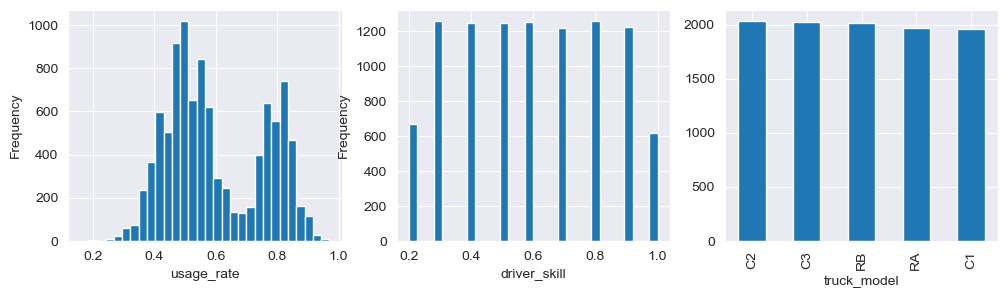

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
df = sample_driver_truck_pairs(n_datapoints, random_seed=0)
df["usage_rate"].plot.hist(bins=30, xlabel="usage_rate", ax=axes[0])
df["driver_skill"].plot.hist(bins=30, xlabel="driver_skill", ax=axes[1])
df["truck_model"].value_counts().plot.bar(ax=axes[2])
df


### Truck models, Brands, UX, Material and Assembly quality

Let's imagine that the assembly quality only depends on the supplier brand.
There are two brands on the market, Robusta (R) and Cheapz (C).

In [6]:
brand_quality = pd.DataFrame(
    {
        "brand": ["Robusta", "Cheapz"],
        "assembly_quality": [0.95, 0.30],
    }
)
brand_quality

,brand,assembly_quality
0,Robusta,0.95
1,Cheapz,0.30



The models have user controls with different UX and driving assistance that
has improved over the years. On the other hands the industry has
progressively evolved to use lower quality materials over the years.

Each truck model come from a specific brand:

In [7]:
trucks = pd.DataFrame(
    {
        "truck_model": truck_model_names,
        "brand": [
            "Robusta" if m.startswith("R") else "Cheapz" for m in truck_model_names
        ],
        "ux": [0.2, 0.5, 0.7, 0.9, 1.0],
        "material_quality": [0.95, 0.92, 0.85, 0.7, 0.65],
    }
).merge(brand_quality)
trucks

,truck_model,brand,ux,material_quality,assembly_quality
0,RA,Robusta,0.2,0.95,0.95
1,C1,Cheapz,0.5,0.92,0.30
2,C2,Cheapz,0.7,0.85,0.30
3,RB,Robusta,0.9,0.70,0.95
4,C3,Cheapz,1.0,0.65,0.30



We can easily augment our truck driver pairs with those extra metadata by
using a join:

In [8]:
def sample_driver_truck_pairs_with_metadata(n_datapoints, random_seed):
    return (
        sample_driver_truck_pairs(n_datapoints, random_seed=random_seed)
        .reset_index()
        .merge(trucks, on="truck_model")
        # Sort by original index to avoid introducing an ordering
        # of the dataset based on the truck_model column.
        .sort_values("index")
        .drop("index", axis="columns")
    )


sample_driver_truck_pairs_with_metadata(10, random_seed=0)

,driver_skill,truck_model,usage_rate,brand,ux,material_quality,assembly_quality
0,0.6,RA,0.62,Robusta,0.2,0.95,0.95
1,0.8,C1,0.48,Cheapz,0.5,0.92,0.30
2,0.7,C1,0.88,Cheapz,0.5,0.92,0.30
3,0.6,RA,0.87,Robusta,0.2,0.95,0.95
4,0.5,C1,0.81,Cheapz,0.5,0.92,0.30
5,0.7,C3,0.55,Cheapz,1.0,0.65,0.30
6,0.6,RB,0.57,Robusta,0.9,0.70,0.95
7,0.9,RA,0.44,Robusta,0.2,0.95,0.95
8,1.0,RB,0.68,Robusta,0.9,0.70,0.95
9,0.5,RA,0.81,Robusta,0.2,0.95,0.95



## Types of Failures

We assume all types of failures follow a [Weibull
distribution](https://en.wikipedia.org/wiki/Weibull_distribution) with
varying shape parameters $k$:

- k < 1: is good to model manufacturing defects, "infant mortality" and
  similar, monotonically decreasing hazards;
- k = 1: constant hazards (exponential distribution): random events not
  related to time (e.g. driving accidents);
- k > 1: "aging" process, wear and tear... monotonically increasing hazards.

The hazard function can be implemented as:

In [9]:
def weibull_hazard(t, k=1.0, s=1.0, t_shift=100, base_rate=1e2):
    # See: https://en.wikipedia.org/wiki/Weibull_distribution
    # t_shift is a trick to avoid avoid negative powers at t=0 when k < 1.
    # t_shift could be interpreted at the operation time at the factory for
    # quality assurance checks for instance.
    t = t + t_shift
    return base_rate * (k / s) * (t / s) ** (k - 1.0)

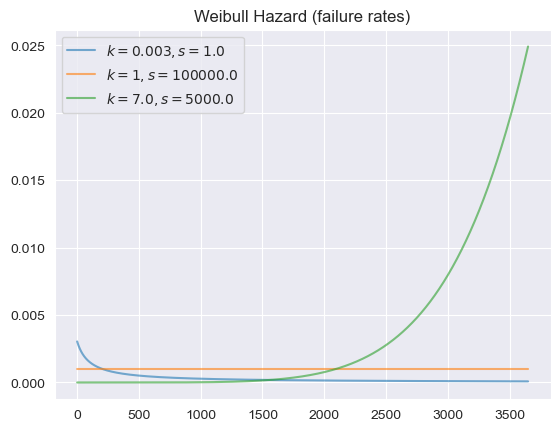

In [10]:
fig, ax = plt.subplots()

t = np.linspace(0, total_days, total_days)  # in days
for k, s in [(0.003, 1.0), (1, 1e5), (7.0, 5e3)]:
    y = weibull_hazard(t, k=k, s=s)  # rate of failures / day
    ax.plot(t, y, alpha=0.6, label=f"$k={k}, s={s}$")
ax.set(
    title="Weibull Hazard (failure rates)",
)
_ = plt.legend()


## Assembly failure $e_1$

Let $\lambda_1$ be the hazard related to the event $e_1$. We model the
$\lambda_1$ with Weibull hazards with k << 1.

Therefore for the assembly failure $e_1$,

$$\lambda_1 \propto \mathrm{usage\; rate} \times (1 - \mathrm{assembly\;
quality})$$


,driver_skill,truck_model,usage_rate,brand,ux,material_quality,assembly_quality
0,0.6,C2,0.60,Cheapz,0.7,0.85,0.30
1,0.8,C3,0.79,Cheapz,1.0,0.65,0.30
2,0.7,RA,0.70,Robusta,0.2,0.95,0.95
3,0.6,RA,0.59,Robusta,0.2,0.95,0.95
4,0.5,C3,0.54,Cheapz,1.0,0.65,0.30


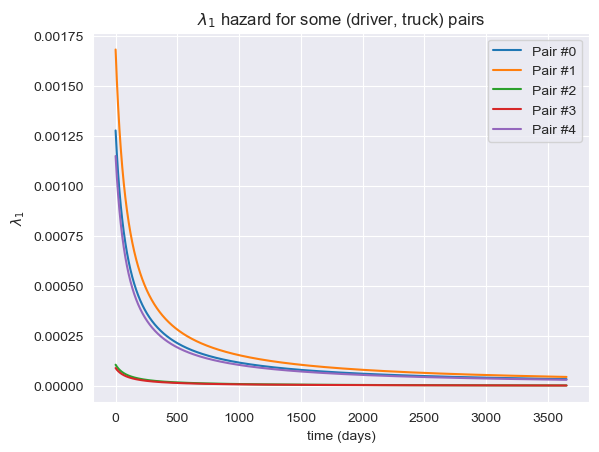

In [11]:
t = np.linspace(0, total_days, total_days)


def assembly_hazards(df, t):
    baseline = weibull_hazard(t, k=0.003)
    s = (df["usage_rate"] * (1 - df["assembly_quality"])).to_numpy()
    return s.reshape(-1, 1) * baseline.reshape(1, -1)


fig, ax = plt.subplots()
subsampled_df = sample_driver_truck_pairs_with_metadata(5, random_seed=0)
hazards_1 = assembly_hazards(subsampled_df, t)
for idx, h1 in enumerate(hazards_1):
    ax.plot(t, h1, label=f"Pair #{idx}")
ax.set(
    title=r"$\lambda_1$ hazard for some (driver, truck) pairs",
    xlabel="time (days)",
    ylabel=r"$\lambda_1$",
)
plt.legend()
subsampled_df


This seems to indicate that drivers of Cheapz trucks have a significantly
larger risk to run into a manufacturing defect during the first 2 years.
Let's confirm this by computing the mean hazards per brands on a a much
larger sample:

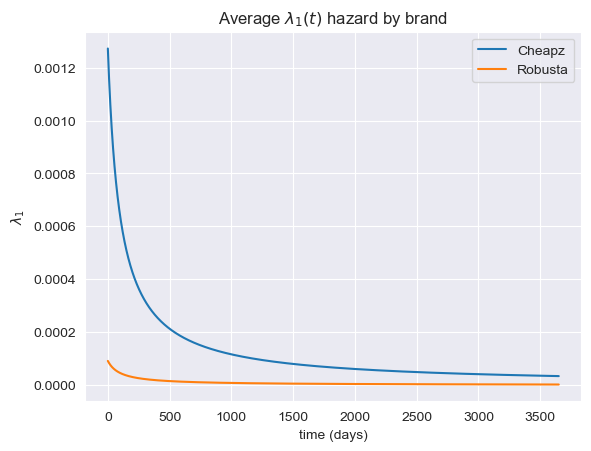

In [12]:
df = sample_driver_truck_pairs_with_metadata(n_datapoints, random_seed=0)
hazards_1 = assembly_hazards(df, t)

fig, ax = plt.subplots()
for brand in df["brand"].unique():
    mask_brand = df["brand"] == brand
    mean_hazards = hazards_1[mask_brand].mean(axis=0)
    ax.plot(t, mean_hazards, label=brand)
ax.set(
    title=r"Average $\lambda_1(t)$ hazard by brand",
    xlabel=r"time (days)",
    ylabel=r"$\lambda_1$",
)
_ = plt.legend()


## Operation failure $e_2$

We consider the operation hazard to be a constant modulated by driver skills, UX and usage rate.

In [13]:
def operational_hazards(df, t):
    # Weibull hazards with k = 1 is just a constant over time:
    baseline = weibull_hazard(t, k=1, s=8e3)
    s = (
        ((1 - df["driver_skill"]) * (1 - df["ux"]) + 0.001) * df["usage_rate"]
    ).to_numpy()
    return s.reshape(-1, 1) * baseline.reshape(1, -1)


hazards_2 = operational_hazards(df, t)

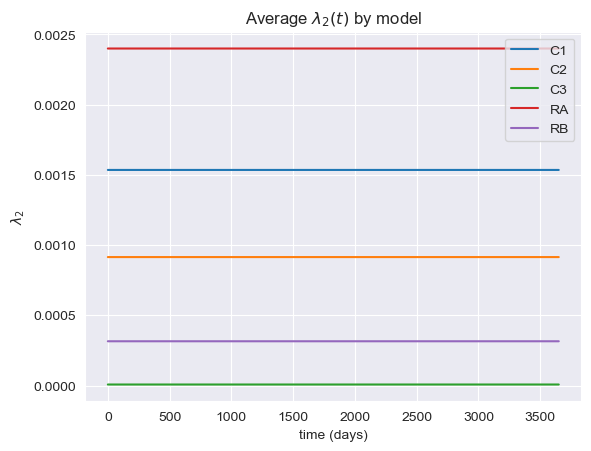

In [14]:
models = sorted(df["truck_model"].unique())

fig, ax = plt.subplots()
for model in models:
    mask_model = df["truck_model"] == model
    mean_hazards = hazards_2[mask_model].mean(axis=0)
    ax.plot(t, mean_hazards, label=model)
ax.set(
    title=r"Average $\lambda_2(t)$ by model",
    xlabel="time (days)",
    ylabel=r"$\lambda_2$",
)
_ = plt.legend()


## Fatigue failure $e_3$

We now model fatigue related features with Weibull hazards with k > 1.

In [15]:
def fatigue_hazards(df, t):
    return np.vstack(
        [
            0.5 * weibull_hazard(t, k=6 * material_quality, s=4e3) * usage_rate
            for material_quality, usage_rate in zip(
                df["material_quality"], df["usage_rate"]
            )
        ]
    )


hazards_3 = fatigue_hazards(df, t)

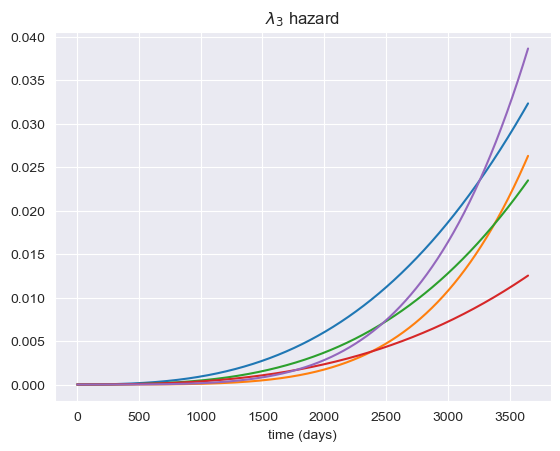

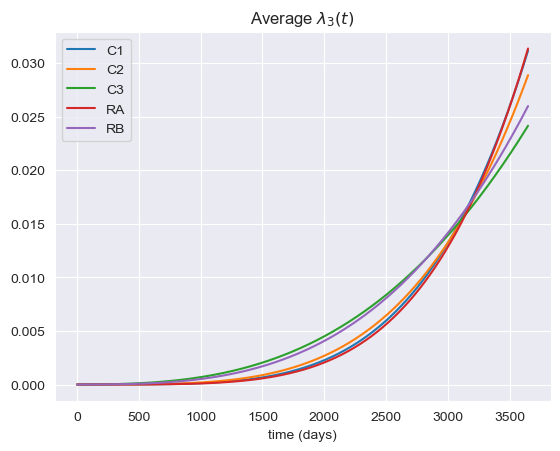

In [16]:
fig, ax = plt.subplots()
for h_3_ in hazards_3[:5]:
    ax.plot(t, h_3_)
ax.set(title=r"$\lambda_3$ hazard", xlabel="time (days)")

fig, ax = plt.subplots()
for model in models:
    mask_model = df["truck_model"] == model
    hazards_mean = hazards_3[mask_model].mean(axis=0)
    ax.plot(t, hazards_mean, label=model)
ax.set(
    title=r"Average $\lambda_3(t)$",
    xlabel="time (days)",
)
_ = plt.legend()


## Additive hazard curve (any event curve)

Let's enhance our understanding of these hazards by plotting the additive
(any event) hazards for some couple (operator, machine).

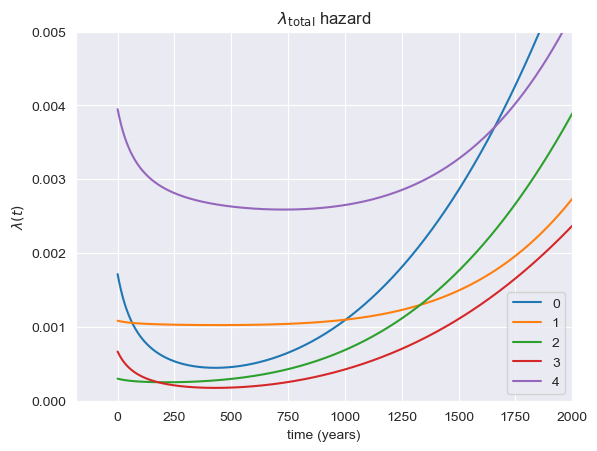

In [17]:
hazards_1.shape, hazards_2.shape, hazards_3.shape

hazards_1.nbytes / 1e6

total_hazards = hazards_1[:5] + hazards_2[:5] + hazards_3[:5]
fig, ax = plt.subplots()
for idx, total_hazards_ in enumerate(total_hazards):
    ax.plot(t, total_hazards_, label=idx)
ax.set(
    title=r"$\lambda_{\mathrm{total}}$ hazard",
    xlabel="time (years)",
    ylabel=r"$\lambda(t)$",
    xlim=[None, 2000],
    ylim=[-0.00001, 0.005],
)
_ = plt.legend()


## Sampling from all hazards

Now that we have the event hazards for the entire period of observation, we
can sample the failure for all (driver, truck) pairs and define our target.

Our target `y` is comprised of two columns:
- `event`: 1, 2, 3 or 0 if no event occurred during the period or if the
observation was censored;
- `duration`: the day when the event or censor was observed.

In [18]:
from scipy.stats import bernoulli


def sample_events_by_type(hazards, random_state=None):
    rng = check_random_state(random_state)
    outcomes = bernoulli.rvs(hazards, random_state=rng)
    any_event_mask = np.any(outcomes, axis=1)
    duration = np.full(outcomes.shape[0], fill_value=total_days)
    occurrence_rows, occurrence_cols = np.where(outcomes)
    # Some individuals might have more than one event occurrence,
    # we only keep the first one.
    # ex: trials = [[0, 0, 1, 0, 1]] -> duration = 2
    _, first_occurrence_idxs = np.unique(occurrence_rows, return_index=True)
    duration[any_event_mask] = occurrence_cols[first_occurrence_idxs]
    jitter = rng.rand(duration.shape[0])
    return pd.DataFrame(dict(event=any_event_mask, duration=duration + jitter))


Let's count the number of events of each type that would occur if event types
were non-competing:

In [19]:
rng = check_random_state(0)
occurrences_1 = sample_events_by_type(hazards_1, random_state=rng)
print(
    f"total events: {occurrences_1['event'].sum()}, "
    f"mean duration: {occurrences_1.query('event')['duration'].mean():.2f} days"
)

occurrences_2 = sample_events_by_type(hazards_2, random_state=rng)
print(
    f"total events: {occurrences_2['event'].sum()}, "
    f"mean duration: {occurrences_2.query('event')['duration'].mean():.2f} days"
)

occurrences_3 = sample_events_by_type(hazards_3, random_state=rng)
print(
    f"total events: {occurrences_3['event'].sum()}, "
    f"mean duration: {occurrences_3.query('event')['duration'].mean():.2f} days"
)

total events: 2428, mean duration: 796.74 days


total events: 6540, mean duration: 881.14 days


total events: 10000, mean duration: 1721.41 days



Let's compute the result of the competing events buy only considering the
first event for each driver / truck pair.

In [20]:
def first_event(event_frames, event_ids):
    event = np.zeros(event_frames[0].shape[0], dtype=np.int32)
    max_duration = np.max([ef["duration"].max() for ef in event_frames])
    duration = np.full_like(event_frames[0]["duration"], fill_value=max_duration)

    out = pd.DataFrame(
        {
            "event": event,
            "duration": duration,
        }
    )
    for event_id, ef in zip(event_ids, event_frames):
        mask = ef["event"] & (ef["duration"] < out["duration"])
        out.loc[mask, "event"] = event_id
        out.loc[mask, "duration"] = ef.loc[mask, "duration"]
    return out


competing_events = first_event(
    [occurrences_1, occurrences_2, occurrences_3], event_ids=[1, 2, 3]
)

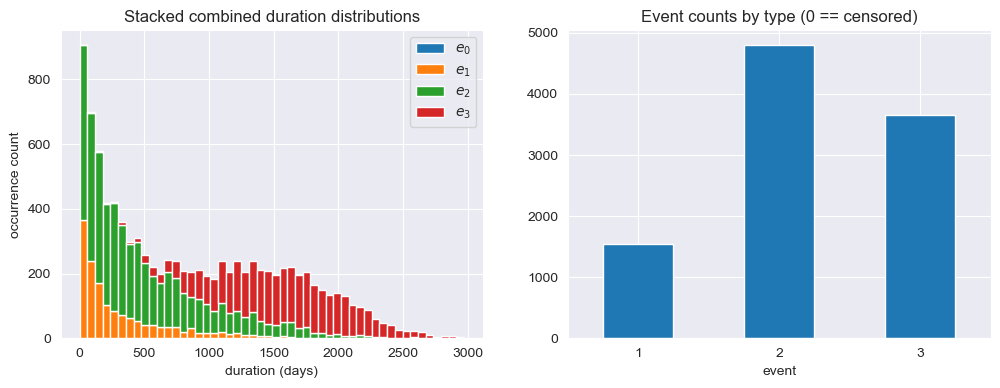

In [21]:
def plot_stacked_occurrences(occurrences):
    hists = [occurrences.query("event == @idx")["duration"] for idx in range(4)]
    labels = [f"$e_{idx}$" for idx in range(4)]
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    axes[0].hist(hists, bins=50, stacked=True, label=labels)
    axes[0].set(
        xlabel="duration (days)",
        ylabel="occurrence count",
        title="Stacked combined duration distributions",
    )
    axes[0].legend()
    occurrences["event"].value_counts().sort_index().plot.bar(rot=0, ax=axes[1])
    axes[1].set(title="Event counts by type (0 == censored)")


plot_stacked_occurrences(competing_events)


Let's now write a function to add non-informative (independent uniform censoring):

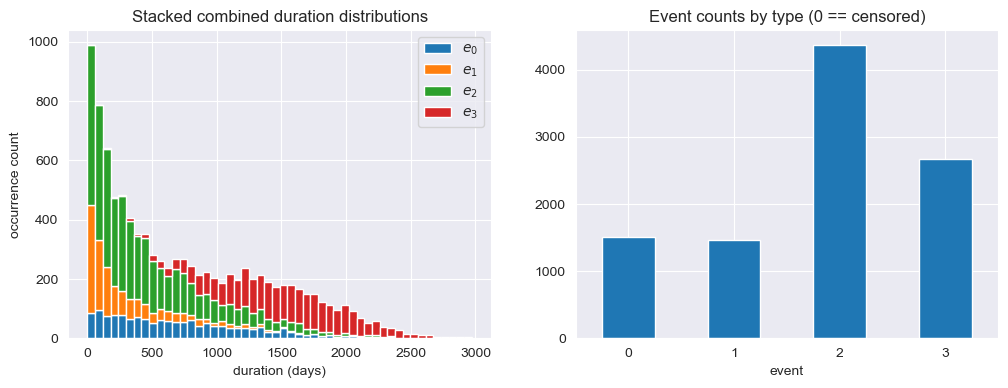

In [22]:
def uniform_censoring(occurrences, censoring_weight=0.5, offset=0, random_state=None):
    n_datapoints = occurrences.shape[0]
    rng = check_random_state(random_state)
    max_duration = occurrences["duration"].max()
    censoring_durations = rng.randint(low=offset, high=max_duration, size=n_datapoints)
    # reduce censoring randomly by setting durations back to the max,
    # effectively ensuring that a fraction of the datapoints will not
    # be censured.
    disabled_censoring_mask = rng.rand(n_datapoints) > censoring_weight
    censoring_durations[disabled_censoring_mask] = max_duration
    out = occurrences.copy()
    censor_mask = occurrences["duration"] > censoring_durations
    out.loc[censor_mask, "event"] = 0
    out.loc[censor_mask, "duration"] = censoring_durations[censor_mask]
    return out


censored_events = uniform_censoring(competing_events, random_state=0)
plot_stacked_occurrences(censored_events)


It is often the case that there is deterministic component to the censoring
distribution that stems from a maximum observation duration:

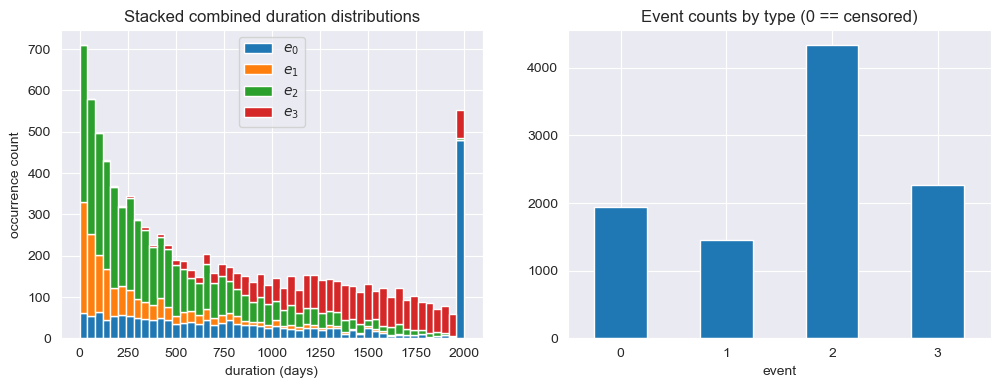

In [23]:
max_observation_duration = 2000
max_duration_mask = censored_events["duration"] > max_observation_duration
censored_events.loc[max_duration_mask, "duration"] = max_observation_duration
censored_events.loc[max_duration_mask, "event"] = 0
plot_stacked_occurrences(censored_events)


# Let's put it all data generation steps together.

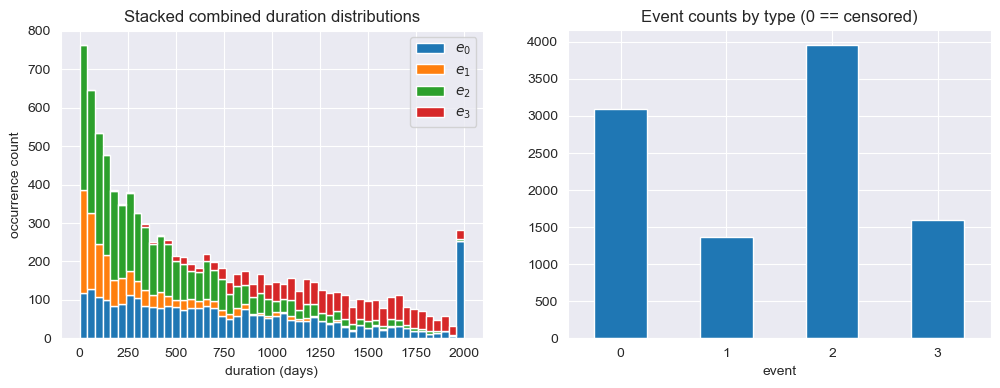

In [24]:
def sample_competing_events(
    data,
    uniform_censoring_weight=1.0,
    max_observation_duration=2000,
    random_seed=None,
):
    rng = check_random_state(random_seed)
    t = np.linspace(0, total_days, total_days)
    hazard_funcs = [
        assembly_hazards,
        operational_hazards,
        fatigue_hazards,
    ]
    event_ids = np.arange(len(hazard_funcs)) + 1
    all_hazards = np.asarray([hazard_func(data, t) for hazard_func in hazard_funcs])
    occurrences_by_type = [
        sample_events_by_type(all_hazards[i], random_state=rng)
        for i in range(all_hazards.shape[0])
    ]
    occurrences = first_event(occurrences_by_type, event_ids)
    censored_occurrences = uniform_censoring(
        occurrences, censoring_weight=uniform_censoring_weight, random_state=rng
    )
    if max_observation_duration is not None:
        # censor all events after max_observation_duration
        max_duration_mask = censored_occurrences["duration"] > max_observation_duration
        censored_occurrences.loc[max_duration_mask, "duration"] = (
            max_observation_duration
        )
        censored_occurrences.loc[max_duration_mask, "event"] = 0
    return (
        censored_occurrences,
        occurrences,
        all_hazards,  # shape = (n_event_types, n_observations, n_timesteps)
    )


truck_failure_10k = sample_driver_truck_pairs_with_metadata(10_000, random_seed=0)
(
    truck_failure_10k_events,
    truck_failure_10k_events_uncensored,
    truck_failure_10k_all_hazards,
) = sample_competing_events(truck_failure_10k, random_seed=0)
plot_stacked_occurrences(truck_failure_10k_events)

In [25]:
truck_failure_10k

,driver_skill,truck_model,usage_rate,brand,ux,material_quality,assembly_quality
0,0.6,C3,0.80,Cheapz,1.0,0.65,0.30
1,0.8,RA,0.50,Robusta,0.2,0.95,0.95
2,0.7,RB,0.55,Robusta,0.9,0.70,0.95
3,0.6,C3,0.31,Cheapz,1.0,0.65,0.30
4,0.5,C1,0.75,Cheapz,0.5,0.92,0.30
...,...,...,...,...,...,...,...
9995,0.6,RA,0.76,Robusta,0.2,0.95,0.95
9996,0.5,RB,0.75,Robusta,0.9,0.70,0.95
9997,0.8,C2,0.64,Cheapz,0.7,0.85,0.30
9998,0.2,C1,0.63,Cheapz,0.5,0.92,0.30



Let's check that the Kaplan-Meier estimator can estimate the mean "any event"
survival function. We compare this estimate to the theoretical mean survival
function computed from the conditional hazard functions from which the event
data has been sampled:

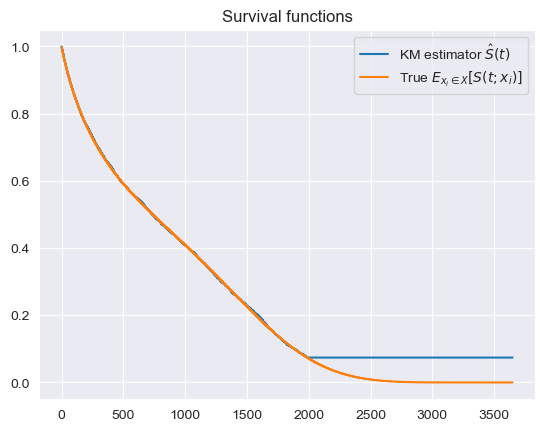

In [26]:
from sksurv.nonparametric import kaplan_meier_estimator
from scipy.interpolate import interp1d


def plot_survival_function(event_frame, all_hazards):
    assert all_hazards.shape[0] == event_frame.query("event != 0")["event"].nunique()
    assert all_hazards.shape[1] == event_frame.shape[0]  # observations
    assert all_hazards.shape[2] >= event_frame["duration"].max()  # days

    any_event = event_frame["event"] > 0
    km_times, km_surv_probs = kaplan_meier_estimator(any_event, event_frame["duration"])

    # Make it possible to evaluate the survival probabilities at any time step with
    # with constant extrapolation if necessary.
    times = np.arange(total_days)
    surv_func = interp1d(
        km_times,
        km_surv_probs,
        kind="previous",
        bounds_error=False,
        fill_value="extrapolate",
    )
    surv_probs = surv_func(times)

    any_event_hazards = all_hazards.sum(axis=0)
    true_surv = np.exp(-any_event_hazards.cumsum(axis=-1))

    plt.step(times, surv_probs, label=r"KM estimator $\hat{S}(t)$")
    plt.step(times, true_surv.mean(axis=0), label=r"True $E_{x_i \in X} [S(t; x_i)]$")
    plt.legend()
    plt.title("Survival functions")


plot_survival_function(truck_failure_10k_events, truck_failure_10k_all_hazards)


The Aalan-Johansen estimator allows us to compute the cumulative incidence function $P(T < t)$ for competitive events.
We compare its estimation to the ground truth by converting our fixed hazards to CIF.

$$CIF_k(t) = \int^t_0 f(u) du = \int^t_0 \lambda_k(u).S(u) du $$

Where $f(t)$ is the probability density, $CIF_k(t)$ is the cumulative incidence function, $\lambda_k(t)$ is the hazard rate of event $k$ and $S(t)$ is the survival probability.

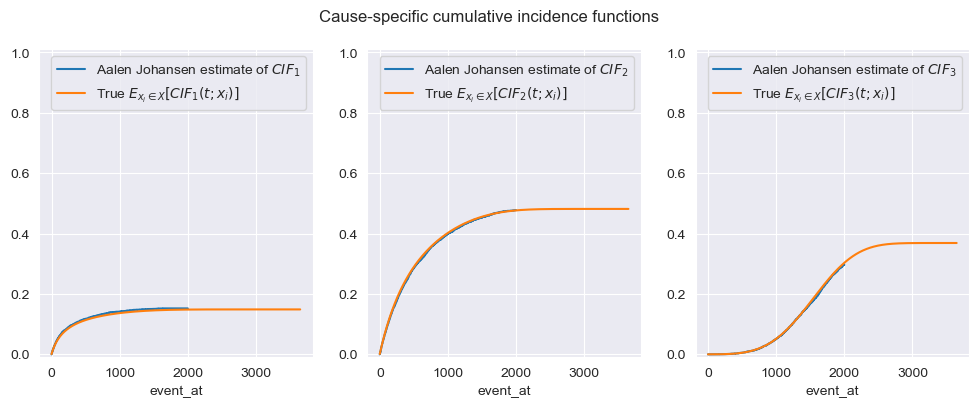

In [27]:
from lifelines import AalenJohansenFitter


def plot_cumulative_incidence_functions(
    event_frame, all_hazards, calculate_variance=False
):
    # `calculate_variance` can be set to True to display confidence intervales
    # but it is slow.
    fig, axes = plt.subplots(figsize=(12, 4), ncols=all_hazards.shape[0])

    any_event_hazards = all_hazards.sum(axis=0)
    true_surv = np.exp(-any_event_hazards.cumsum(axis=-1))

    plt.suptitle("Cause-specific cumulative incidence functions")
    for event_id, (ax, hazards_i) in enumerate(zip(axes, all_hazards), 1):

        ajf = AalenJohansenFitter(calculate_variance=calculate_variance)
        ajf.fit(
            event_frame["duration"], event_frame["event"], event_of_interest=event_id
        )
        ajf.plot(label=f"Aalen Johansen estimate of $CIF_{event_id}$", ax=ax)

        cif = (hazards_i * true_surv).cumsum(axis=-1).mean(axis=0)
        ax.plot(cif, label=r"True $E_{x_i \in X}" + f"[CIF_{event_id}(t; x_i)]$"),
        ax.set(ylim=[-0.01, 1.01]),
        ax.legend()


plot_cumulative_incidence_functions(
    truck_failure_10k_events, truck_failure_10k_all_hazards
)


Sanity check for our Brier score computation: it should approximately return
the same values irrespective of the censoring for each event type:

In [28]:
from hazardous.metrics import integrated_brier_score_incidence


any_event_hazards = truck_failure_10k_all_hazards.sum(axis=0)
true_survival = np.exp(-any_event_hazards.cumsum(axis=-1))
max_time_ibs = int(truck_failure_10k_events.query("event > 0")["duration"].max()) - 1

for i, hazards_i in enumerate(truck_failure_10k_all_hazards):
    k = i + 1
    true_cif_k = (hazards_i * true_survival).cumsum(axis=-1)
    ibs_censored = integrated_brier_score_incidence(
        truck_failure_10k_events,
        truck_failure_10k_events,
        true_cif_k[:, :max_time_ibs],
        np.arange(total_days)[:max_time_ibs],
        event_of_interest=k,
    )
    ibs_uncensored = integrated_brier_score_incidence(
        truck_failure_10k_events_uncensored,
        truck_failure_10k_events_uncensored,
        true_cif_k[:, :max_time_ibs],
        np.arange(total_days)[:max_time_ibs],
        event_of_interest=k,
    )
    print(
        f"IBS for event {k}: censored {ibs_censored:.4f}, uncensored {ibs_uncensored:.4f}"
    )

IBS for event 1: censored 0.0995, uncensored 0.0999


IBS for event 2: censored 0.1242, uncensored 0.1240


IBS for event 3: censored 0.0582, uncensored 0.0587



If all is well, let's save this dataset to disk:

In [29]:
observed_variables = [
    "driver_skill",
    "brand",
    "truck_model",
    "usage_rate",
]
truck_failure_10k[observed_variables].to_parquet(
    "truck_failure_10k_features.parquet", index=False
)
truck_failure_10k_events.to_parquet(
    "truck_failure_10k_competing_risks.parquet", index=False
)
truck_failure_10k_events_uncensored.to_parquet(
    "truck_failure_10k_competing_risks_uncensored.parquet", index=False
)

truck_failure_10k_any_event = truck_failure_10k_events.copy()
truck_failure_10k_any_event["event"] = truck_failure_10k_any_event["event"] > 0
truck_failure_10k_any_event.to_parquet(
    "truck_failure_10k_any_event.parquet", index=False
)

truck_failure_10k_any_event_uncensored = truck_failure_10k_events_uncensored.copy()
truck_failure_10k_any_event_uncensored["event"] = (
    truck_failure_10k_any_event["event"] > 0
)
truck_failure_10k_any_event_uncensored.to_parquet(
    "truck_failure_10k_any_event_uncensored.parquet", index=False
)


Let's also save the underlying hazard functions used to sample each event of
the dataset.

In [30]:
np.savez_compressed(
    "truck_failure_10k_hazards.npz",
    truck_failure_10k_hazards=truck_failure_10k_all_hazards,
)

In [31]:
with np.load("truck_failure_10k_hazards.npz") as hazards_file:
    array_names = list(hazards_file.keys())

array_names

['truck_failure_10k_hazards']


## Sampling a larger dataset (without ground truth)

Let's sample a larger event dataset to be able to assess the sample and
computational complexities of various predictive methods:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   18.1s remaining:   42.3s


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   18.5s remaining:    7.9s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.3s finished


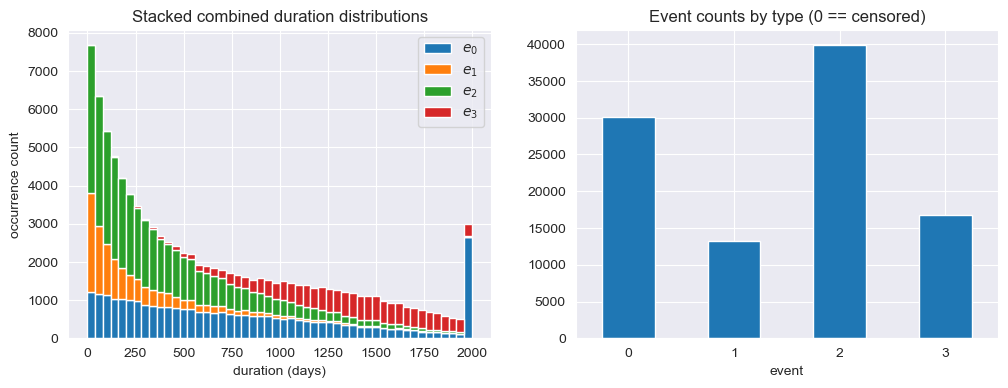

In [32]:
from joblib import Parallel, delayed

chunk_size = 10_000
n_chunks = 10


def sample_chunk(chunk_idx, chunk_size):
    features_chunk = sample_driver_truck_pairs_with_metadata(
        chunk_size, random_seed=chunk_idx
    )
    events_chunk, _, _ = sample_competing_events(features_chunk, random_seed=chunk_idx)
    return features_chunk, events_chunk


results = Parallel(n_jobs=-1, verbose=10)(
    delayed(sample_chunk)(i, chunk_size) for i in range(n_chunks)
)
truck_failure_100k = pd.concat(
    [features_chunk for features_chunk, _ in results], axis="rows"
)
truck_failure_100k_events = pd.concat(
    [events_chunk for _, events_chunk in results], axis="rows"
)
plot_stacked_occurrences(truck_failure_100k_events)


Note: we ensured that the chunk size is 10_000 and the random seed is based
on the chunk index to ensure that the `truck_failure_100k` dataset is a super
set of the `truck_failure_10k` dataset.

In [33]:
from pandas.testing import assert_frame_equal

assert_frame_equal(
    truck_failure_100k[observed_variables].iloc[:10_000].reset_index(drop=True),
    truck_failure_10k[observed_variables].reset_index(drop=True),
)
assert_frame_equal(
    truck_failure_100k[observed_variables].iloc[:10_000].reset_index(drop=True),
    truck_failure_10k[observed_variables].reset_index(drop=True),
)

In [34]:
truck_failure_100k[observed_variables].to_parquet(
    "truck_failure_100k_features.parquet", index=False
)
truck_failure_100k_events.to_parquet(
    "truck_failure_100k_competing_risks.parquet", index=False
)
truck_failure_100k_any_event = truck_failure_100k_events.copy()
truck_failure_100k_any_event["event"] = truck_failure_100k_any_event["event"] > 0
truck_failure_100k_any_event.to_parquet(
    "truck_failure_100k_any_event.parquet", index=False
)


## Sampling targets at fixed conditional X

We now fix our covariates X to the first truck-driver pair, and create a
fixed dataset by sampling $N$ times our first user multi-event hazards. The
goal is to check that an unconditional estimator designed for competing
events, called Aalen-Johanson, gives hazards estimations close to the ground
truth.

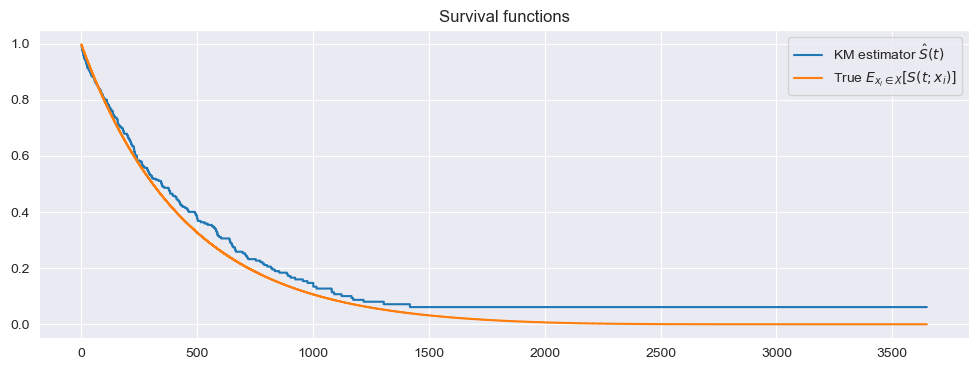

<Figure size 1200x400 with 0 Axes>

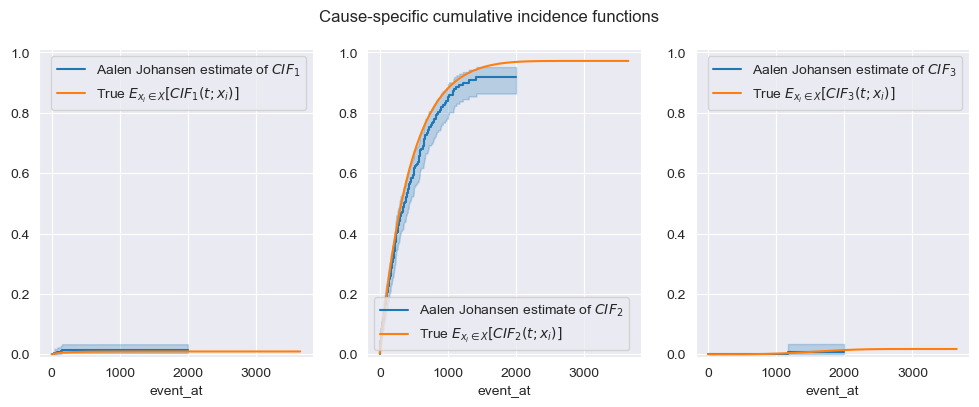

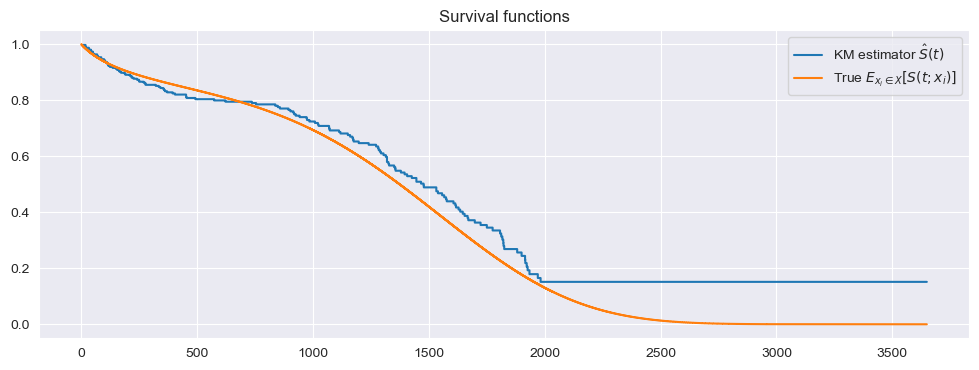

<Figure size 1200x400 with 0 Axes>

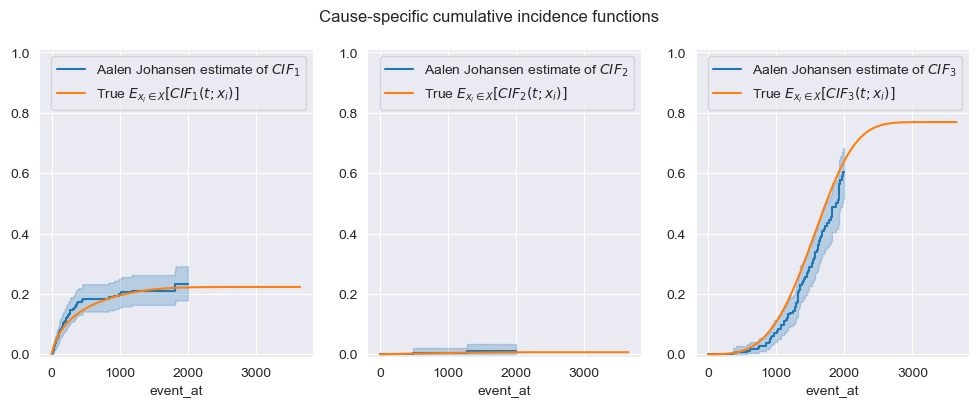

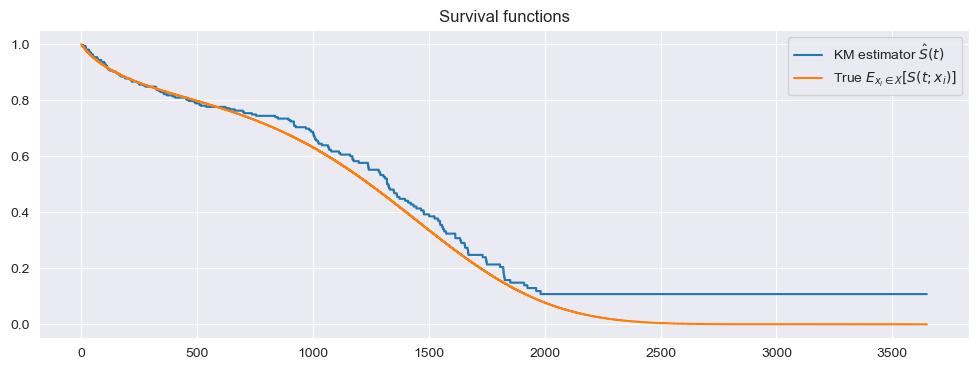

<Figure size 1200x400 with 0 Axes>

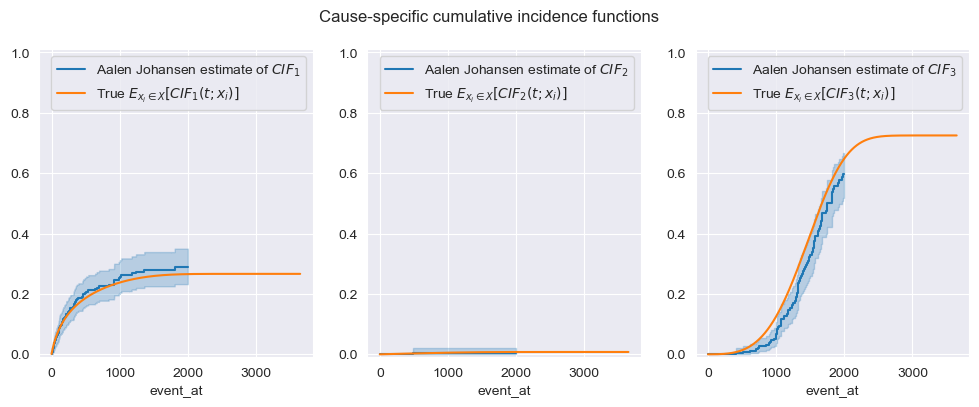

In [35]:
for seed in [40, 41, 42]:
    truck_failure_fc = sample_driver_truck_pairs_with_metadata(1, random_seed=seed)
    truck_failure_fc = pd.concat([truck_failure_fc] * 300, axis="rows").reset_index(
        drop=True
    )
    truck_failure_fc

    (
        truck_failure_fc_events,
        truck_failure_fc_events_uncensored,
        all_hazards_fc,
    ) = sample_competing_events(truck_failure_fc, random_seed=42)
    # plot_stacked_occurrences(truck_failure_fc_events)
    _ = plt.figure(figsize=(12, 4))
    plot_survival_function(truck_failure_fc_events, all_hazards_fc)

    _ = plt.figure(figsize=(12, 4))
    plot_cumulative_incidence_functions(
        truck_failure_fc_events, all_hazards_fc, calculate_variance=True
    )


We should see that the Aalen-Johansen method provides an accurate estimators
for the unconditional competing hazards, even with few samples!